In [1]:
from transformers import pipeline
from nltk import sent_tokenize
import torch
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt_tab')


c:\work\ml\nlp analysis\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\navne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Load Model

In [2]:
model_name = "facebook/bart-large-mnli"
device = 0 if torch.cuda.is_available() else 'cpu'

def load_model(device):
    theme_classifier = pipeline(
        "zero-shot-classification",
        model=model_name,
        device=device
    )

    return theme_classifier

theme_classifier = load_model(device)

# Load Dataset

In [98]:
def load_subtitles_dataset(dataset_path):
    df = pd.read_csv(dataset_path)
    df['season_episode'] = (df['Season'].str.split(' ').str[1].astype(int) - 1) * 10 + df['Episode'].str.split(' ').str[1].astype(int)
    df_a = df.drop(['Season','Episode','Name','Release Date','Episode Title'],axis=1)
    df_a['Sentence'] = df_a['Sentence'].astype(str)
    df_a = df_a.groupby('season_episode')['Sentence'].agg(' '.join).reset_index()
    df_a.rename(columns={'Sentence':'Subtitles'},inplace=True)
    
    


    return df_a

In [3]:
def load_subtitles_dataset_classified(dataset_path):
    df = pd.read_csv(dataset_path)
    df['season_episode'] = (df['Season'].str.split(' ').str[1].astype(int) - 1) * 10 + df['Episode'].str.split(' ').str[1].astype(int)
    df_a = df.drop(['Season','Episode','Release Date','Episode Title'],axis=1)
    df_a['Sentence'] = df_a['Sentence'].astype(str)
    df_a.rename(columns={'Sentence':'Subtitles'},inplace=True)
    
    return df_a

In [27]:
df = load_subtitles_dataset_classified("C:/work/ml/nlp analysis/data/GOT.csv")
df.head()

,Name,Subtitles,season_episode
0,waymar royce,What do you expect? They're savages. One lot s...,1
1,will,I've never seen wildlings do a thing like this...,1
2,waymar royce,How close did you get?,1
3,will,Close as any man would.,1
4,gared,We should head back to the wall.,1


In [ ]:
# dataset_path = "C:/work/ml/analyze_series_with_NLP/data/GOT.csv"
# df = load_subtitles_dataset(dataset_path)

### Run Model

In [28]:
script = df[df['season_episode'] == 1]
script = script['Subtitles']

In [29]:
script_sentences =script.to_list()

In [47]:
def get_themes_inference(script_sentences,theme_list):

    # Batch Sentence
    sentence_batch_size=20
    script_batches = []
    for index in range(0,len(script_sentences),sentence_batch_size):
        sent = " ".join(script_sentences[index:index+sentence_batch_size])
        script_batches.append(sent)
    
    # Run Model
    theme_output = theme_classifier(
        script_batches,
        theme_list,
        multi_label=True
    )

    # Wrangle Output 
    themes = {}
    for output in theme_output:
        for label,score in zip(output['labels'],output['scores']):
            if label not in themes:
                themes[label] = []
            themes[label].append(score)

    themes = {key: np.mean(np.array(value)) for key,value in themes.items()}

    return themes

In [48]:
theme_list = ["friendship","hope","arrogance","battle","fear","betrayal","love","dialogue"]
output_themes = get_themes_inference(script_sentences[:20],theme_list)

In [49]:
output_themes

{'fear': np.float64(0.8121963143348694),
 'dialogue': np.float64(0.7827713489532471),
 'hope': np.float64(0.7617592215538025),
 'battle': np.float64(0.7453933358192444),
 'betrayal': np.float64(0.6147357225418091),
 'love': np.float64(0.48467081785202026),
 'arrogance': np.float64(0.4553791880607605),
 'friendship': np.float64(0.3537886142730713)}

In [ ]:
theme_df = pd.DataFrame(output_themes, index=[0])
theme_df = theme_df.sum().reset_index()
theme_df.columns = ['Theme','Score']

In [57]:
theme_df

,Theme,Score
0,fear,0.812196
1,dialogue,0.782771
2,hope,0.761759
3,battle,0.745393
4,betrayal,0.614736
5,love,0.484671
6,arrogance,0.455379
7,friendship,0.353789


# Visualize ouput

In [37]:
df = df.drop('dialogue',axis=1)

In [42]:
theme_output = df.drop(['season_episode','Subtitles'],axis=1).sum().reset_index()
theme_output.columns = ['theme','score']
theme_output

,theme,score
0,fear,1.094961
1,betrayal,1.059324
2,arrogance,1.083465
3,battle,1.121136
4,hope,0.967835
5,friendship,0.467234
6,love,0.396691


In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

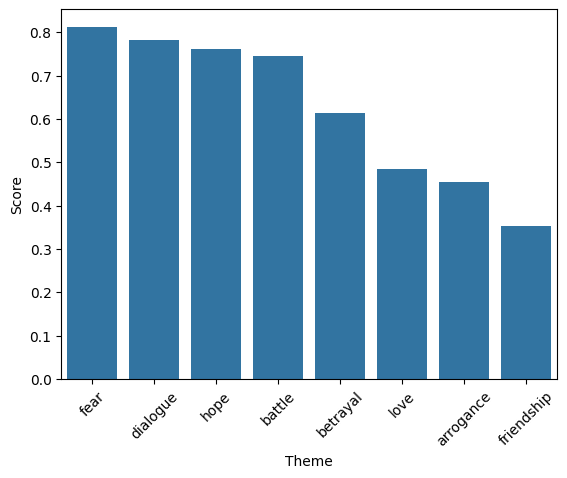

In [60]:
sns.barplot(data = theme_df ,x="Theme",y="Score" )
plt.xticks(rotation=45)
plt.show()